In [2]:
import numpy as np
import matplotlib.pyplot as pl

In [16]:
GM = 4 * np.pi**2 # AU^3 / yr^2

In [17]:
#you won't have my style sheet so don't bother running this cell
pl.style.use("~/Documents/configs/custom.mplstyle")
pl.rcParams['axes.xmargin'] = 0.05

In [ ]:
def grav_acc(r, gm=GM):
    '''
    Compute the gravitational acceleration at a position r = [x,y]

    Arguments
    ---------
    r: Numpy array with 2 elements for the x and y coordinates
    gm: (opt) The product of the gravitational constant and the mass of the central object
        This sets the units of the output. Default uses units of AU, Year, M_solar

    Returns
    -------
    a: gravitational acceleration at input coordinates in units set by GM argument
    '''
    r_mag = np.sqrt(np.sum(r**2))
    return -gm / r_mag**3 * r

def energy(x, gm=GM):
    '''
    Compute the total energy (per unit mass) of a particle subject to gravity

    Arguments
    ---------
    x: (2,2) shape Numpy array with containing the position and velocity as [[x,y],[vx,vy]]
    gm: (opt) The product of the gravitational constant and the mass of the central object
        This sets the units of the output. Default uses units of AU, Year, M_solar

    Returns
    -------
    E: the total energy per unit mass of the particle
    '''
    return -gm/np.sqrt(np.sum(x[0]**2)) + np.sum(x[1]**2) / 2

def rp(a, e):
    '''
    Compute the periastron distance of a Keplerian orbit

    Arguments
    ---------
    a: Semi-major axis of the orbit
    e: ellipticity of the orbit

    Returns
    -------
    r_p: periastron distance (clostest approach distance) of the orbit
    '''
    return a*(1-e)

def vp(a, e, gm=GM):
    '''
    Compute the periastron velocity of a Keplerian orbit

    Arguments
    ---------
    a: Semi-major axis of the orbit
    e: ellipticity of the orbit
    gm: (opt) The product of the gravitational constant and the mass of the central object
        This sets the units of the output. Default uses units of AU, Year, M_solar

    Returns
    -------
    r_p: periastron velocity (velocity of closest approach) of the orbit
    '''
    return (gm * (1+e) / a / (1-e))**0.5

def rk_4(x, dt):
    '''
    Using 4th order Runge-Kutta, compute the position and velocity at the next time step
    of an orbit

    Arguments
    ---------
    x: (2,2) shape Numpy array containing the current time step position and velocity 
        in the form [[x,y], [vx, vy]]
    dt: the size of the time step to make when advancing the solution

    Returns
    -------
    x_next: A (2,2) shape Numpy array containing the position and velocity at a 
            time dt after the input step
    '''
    k1 = dt * np.array([x[1], grav_acc(x[0])])
    k2 = dt * np.array([(x+k1/2)[1], grav_acc((x+k1/2)[0])])
    k3 = dt * np.array([(x+k2/2)[1], grav_acc((x+k2/2)[0])])
    k4 = dt * np.array([(x+k3)[1], grav_acc((x+k3)[0])])
    return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def integrate_orbit(method, n, t, r0=None, v0=None, a=1, e=0):
    '''
    Numerically integrate a Keplerian orbit for a given period of time 
    using a given number of discrete steps

    Arguments
    ---------
    method: function for advancing the solution to the next time step
    n: the number of total time steps to break the interval into
    t: the total time to integrate over
       Units set by GM, default is years
    r0: (opt) Length 2 array-like containing the initial position
        If not given, initialized to periastron position for the
         given 'a' and 'e' 
    v0: (opt) Length 2 array-like containing the initial position
        If not given, initialized to periastron velocity for the
         given 'a' and 'e' 
    a: (opt) Semi-major axis of the orbit in units determined by GM, default is 1 AU
    e: (opt) Ellipticity of the orbit; [0,1)
    
    Returns
    -------
    x: A (2,2, n) shape Numpy array containing the position and velocity at all
        n points of the integrated orbit. Format of each element [:,:,i] is [[x,y], [vx,vy]]

    tot_en: (n)-length array containing the total energy (per unit mass) of the particle
            computed at all the discrete points of the integrated orbit
    '''
    if not r0 and not v0:
        r0 = [0, rp(a,e)]
        v0 = [-vp(a,e), 0]

    n = round(n)
    dt = t/n

    x = np.zeros((2,2,n+1))
    x[:,:,0] = np.array([r0, v0])
    for i in range(n):
        x[:,:,i+1] = method(x[:,:,i], dt)

    tot_en = [energy(x[:,:,i]) for i in range(n)]

    return x, tot_en


def orbit_adaptive(method, t_end, e_tol=1e-4, dt0=1/1000, r0=None, v0=None, a=1, e=0):
    '''
    Numerically integrate a Keplerian orbit for a given period of time 
    using adaptive time steps

    Arguments
    ---------
    method: function for advancing the solution to the next time step
    t_end: the total time to integrate over
           Units set by GM, default is years
    e_tol: Error tolerance to determine the adaptive step size
           If halving the step size gives an error relative
            to the current time step greater than this, reduce
            step size, otherwise increase step size
    dt0: initial time step size 
         Units determined by GM, default is years
    r0: (opt) Length 2 array-like containing the initial position
        If not given, initialized to periastron position for the
         given 'a' and 'e' 
    v0: (opt) Length 2 array-like containing the initial position
        If not given, initialized to periastron velocity for the
         given 'a' and 'e' 
    a: (opt) Semi-major axis of the orbit in units determined by GM, default is 1 AU
    e: (opt) Ellipticity of the orbit; [0,1)
    
    Returns
    -------
    x: A (2,2, n) shape Numpy array containing the position and velocity at all
        n points of the integrated orbit. Format of each element [:,:,i] is [[x,y], [vx,vy]]

    tot_en: (n)-length array containing the total energy (per unit mass) of the particle
            computed at all the discrete points of the integrated orbit

    ts: (n)-length array containing the times corresponding to each 
        discrete point in the solution
    '''
    if not r0 and not v0:
        r0 = [0, rp(a,e)]
        v0 = [-vp(a,e), 0]

    n0 = int(1/dt0)+1
    dt = dt0

    x = np.zeros((2,2,n0))
    ts = np.zeros(n0)
    x[:,:,0] = np.array([r0, v0])

    i = 0
    while ts[i] < t_end:
        if (i == len(ts) - 1):
            ts = np.hstack((ts, np.zeros(n0)))
            x = np.concatenate((x, np.zeros((2,2,n0))), axis=2)

        prop_x = method(x[:,:,i], dt)
        half_x = method(method(x[:,:,i], dt/2), dt/2)

        err = abs(1 - (np.sum(prop_x[0]**2)/np.sum(half_x[0]**2))**0.5)

        if err <= e_tol:
            ts[i+1] = ts[i] + dt
            x[:,:,i+1] = prop_x
            dt = dt * (e_tol / err)**0.2
            i+=1

        else:
            dt = dt * (e_tol / err)**0.2
            continue


    mask = np.sum(x, axis=(0,1)) != 0
    x = x[:,:,mask]
    ts = ts[mask]

    tot_en = [energy(x[:,:,i]) for i in range(x.shape[2])]

    return x, tot_en, ts


In [74]:
years = 1
e = 0.96
pos, en = integrate_orbit(rk_4, years*365, years, e=e)
pos1, en1, ts1 = orbit_adaptive(rk_4, years, e=e, e_tol=1e-5, dt0=1/12)

In [75]:
x = pos[0,0,:].flatten()
y = pos[0,1,:].flatten()

x1 = pos1[0,0,:].flatten()
y1 = pos1[0,1,:].flatten()


circx = np.linspace(-1,1,200)
circy = np.sqrt(1-circx**2)

circ = np.array([np.hstack((circx,np.flip(circx))),np.hstack((circy,np.flip(-circy)))])

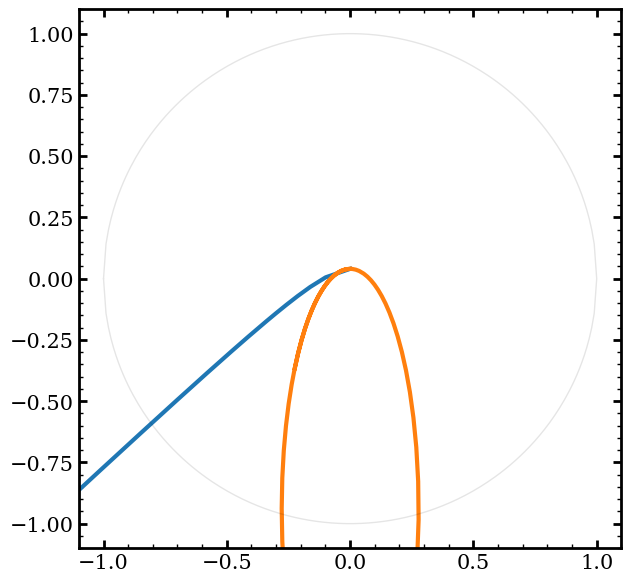

In [76]:
pl.figure(figsize=(7,7))
pl.plot(x,y)
pl.plot(x1, y1)
pl.plot(circ[0], circ[1], c='k', alpha=0.1, lw=1)
pl.xlim(-1.1, 1.1)
pl.ylim(-1.1, 1.1)
pl.show()

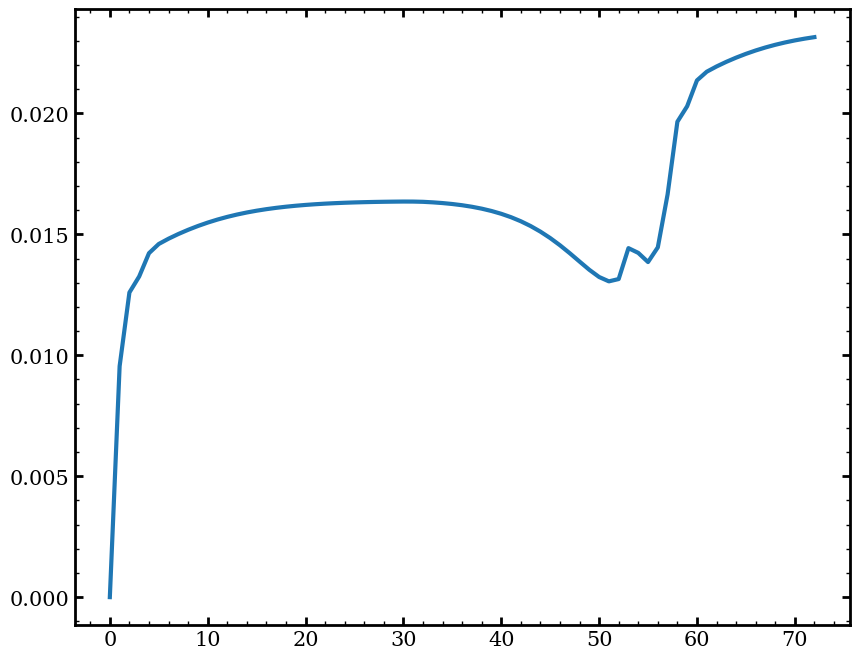

In [77]:
pl.plot(range(len(en1)), en1 / en1[0] - 1)
pl.show()